# Constrained Placement Optimization with SMT

A fun way to solve graphical placement problems is to use SMT constraint optimization. SMT solving engines are very large and very powerful so it's a bit like killing a gnat with a sledge hammer, but framing the problem in terms of the constraints and the cost function is more fun than framing it as a set of procedural steps. So it's probably usually a bad idea, but it is always a fun idea.

## Problem Statement
Given a set of boxes of a given dimension and target destination, find placements of the boxes that minimizes the distance from their target destination where no box overlaps any other box. 

## Data Structures
This solution uses an abundance of data structures even though it's a bit verbose. The solution will be a `Box[]` with every `Box` assigned a position.

In [1]:
from dataclasses import dataclass

@dataclass        
class Dimension:
    width: int
    height: int
    
    def __mul__(self, other):
        return Dimension(self.width * other.width, self.height * other.height)
    
    def __add__(self, other):
        return Dimension(self.width + other.width, self.height + other.height)

    def to_point(self):
        return Point(self.width, self.height)

@dataclass
class Point:
    x: int
    y: int
    
    def __mul__(self, dimension: Dimension):
        return Point(self.x * dimension.width, self.y * dimension.height)
    
    def __add__(self, dimension: Dimension):
        return Point(self.x + dimension.width, self.y + dimension.height)
    

@dataclass
class Rect:
    position: Point
    size: Dimension
    
    def center(self):
        return Point(self.position.x + self.size.width // 2, self.position.y + self.size.height // 2)
        
    def __mul__(self, dimension: Dimension):
        return Rect(self.position * dimension, self.size * dimension)
    
    def __add__(self, dimension: Dimension):
        return Rect(self.position + dimension, self.size)


@dataclass
class Box:
    rect: Rect
    target: Point
    name: str

## Solution Visualization
This is just visualization code to make it easier to see the solution that we found.

In [2]:
import xml.etree.ElementTree as ET
from IPython.display import SVG, display

def draw_boxes(boxes, domain: Dimension):
    margin_dim = Dimension(20, 20)
    node_dim = Dimension(40, 40)
    half_node = Dimension(20, 20)
    board_dim = domain * node_dim
    svg_dims = board_dim + margin_dim * Dimension(2, 2)
    topleft = Point(margin_dim.width, margin_dim.height)
    bottomright = Point((margin_dim+board_dim).width, (margin_dim+board_dim).height)
    svg = ET.fromstring(f'<svg height="{svg_dims.height}" width="{svg_dims.width}"/>')
    svg.append(ET.fromstring('''
        <style>
            line { stroke: black }
            rect { fill: #666; stroke: #999; }
        </style>'''))
    for x in range(domain.width+1):
        line_x = margin_dim.width + x * node_dim.width
        svg.append(ET.fromstring(f'''
            <line
                stroke-dasharray="4 8"
                x1="{line_x}"
                x2="{line_x}"
                y1="{topleft.y}"
                y2="{bottomright.y}"
            />'''))
    for y in range(domain.height+1):
        line_y = margin_dim.height + y * node_dim.height
        svg.append(ET.fromstring(f'''
            <line
                stroke-dasharray="4 8"
                x1="{topleft.x}"
                x2="{bottomright.x}"
                y1="{line_y}"
                y2="{line_y}"
            />'''))
    for box in boxes:
        rect = box.rect * node_dim + margin_dim
        s = f'''
            <rect
                x="{rect.position.x}"
                y="{rect.position.y}"
                width="{rect.size.width}"
                height="{rect.size.height}"
            />
        '''
        svg.append(ET.fromstring(s))
        
    for box in boxes:
        target_point = box.target * node_dim + margin_dim + half_node
        center_point = box.rect.center() * node_dim + margin_dim + half_node
        s = f'''
            <line
                x1="{target_point.x}"
                y1="{target_point.y}"
                x2="{center_point.x}"
                y2="{center_point.y}"
            />
        '''
        svg.append(ET.fromstring(s))
        s = f'''
            <circle
                cx="{target_point.x}"
                cy="{target_point.y}"
                r="4"
                fill="red"
            />
        '''
        svg.append(ET.fromstring(s))
        s = f'''
            <text
                x="{center_point.x}"
                y="{center_point.y}"
            >
                {box.name}
            </text>
        '''
        svg.append(ET.fromstring(s))
    display(SVG(ET.tostring(svg)))

This uses Z3 as the SMT solver. Z3 is pretty large but very powerful. We prefix data structures that have free variables in them with Z to distinguish them from data structures where all values have a fixed value

In [3]:
import z3

def zabs(x):
    return z3.If(x >= 0, x, -x)

@dataclass
class ZPoint:
    x: z3.Int
    y: z3.Int
        
    def manhattan_dist(self, other: Point):
        return zabs(self.x - other.x) + zabs(self.y - other.y)

@dataclass
class ZRect:
    name: str
    position: ZPoint
    size: Dimension
        
    def __init__(self, name: str, size: Dimension):
        self.name = name
        self.size = size
        self.position = ZPoint(z3.Int(name+'.x'), z3.Int(name+'.y'))
    
    def center(self):
        return ZPoint(self.position.x + self.size.width // 2, self.position.y + self.size.height // 2)
    
    def doesnt_overlap_with(self, other):
        too_far_right = self.position.x >= other.position.x + other.size.width
        too_far_left = self.position.x + self.size.width <= other.position.x
        too_far_up = self.position.y + self.size.height <= other.position.y
        too_far_down = self.position.y >= other.position.y + other.size.height
        return z3.Or(too_far_right, too_far_left, too_far_up, too_far_down)
    
    def constrain_domain(self, size:Dimension, solver):
        solver.add(self.position.x >= 0)
        solver.add(self.position.y >= 0)
        solver.add(self.position.x + self.size.width <= size.width)
        solver.add(self.position.y + self.size.height <= size.height)
    
    def to_rect(self, solution: dict):
        return Rect(Point(solution[self.name+'.x'], solution[self.name+'.y']), self.size)

@dataclass
class ZBox:
    rect: ZRect
    target: Point
    
    def to_box(self, solution: dict):
        return Box(self.rect.to_rect(solution), self.target, self.rect.name)

## Constraints

* No box may overlap with any other box
* Must be within the bounds

## Cost Function

The sum of the manhattan distance for all boxes.

In [4]:
def find_placement(zboxes, domain):
    costs = []
    solver = z3.Optimize()
    for box1 in zboxes:
        for box2 in zboxes:
            if box1 is box2:
                continue
            solver.add(box1.rect.doesnt_overlap_with(box2.rect))
        costs.append(box1.rect.center().manhattan_dist(box1.target))
        box1.rect.constrain_domain(domain, solver)
    cost = z3.Int('cost')
    solver.add(cost == z3.Sum(costs))
    solver.minimize(cost)
    solver.check()
    solution = solver.model()
    solution = {str(s):solution[s].as_long() for s in solution if 'z3name!' not in str(s)}
    return [zbox.to_box(solution) for zbox in zboxes]

## Example

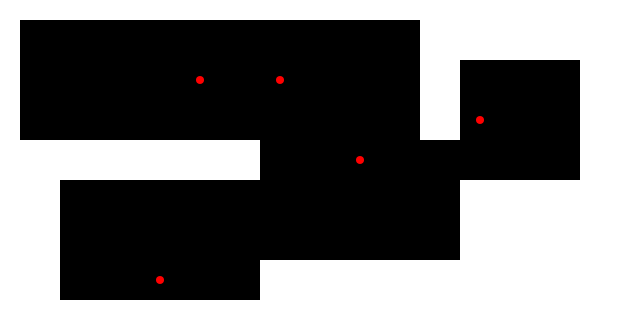

In [5]:
zboxes = [
    ZBox(ZRect('A', Dimension(5, 3)), target=Point(8, 3)),
    ZBox(ZRect('B', Dimension(5, 3)), target=Point(3, 6)),
    ZBox(ZRect('C', Dimension(5, 3)), target=Point(4, 1)),
    ZBox(ZRect('D', Dimension(5, 3)), target=Point(6, 1)),
    ZBox(ZRect('E', Dimension(3, 3)), target=Point(11, 2))
]
domain = Dimension(15, 7)
boxes = find_placement(zboxes, domain)
draw_boxes(boxes, domain)